In [1]:
# Step 1 & 2: Install and import all required libraries

#INSTALLS
# !pip install PyPDF2 py-readability-metrics wordcloud nltk matplotlib pandas

# IMPORTS
import re
import pandas as pd
import matplotlib.pyplot as plt

# PDF extraction
import PyPDF2

# Text analysis & NLP
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, sent_tokenize

# Readability metrics
from readability import Readability

# Word cloud
from wordcloud import WordCloud, STOPWORDS

#DOWNLOAD REQUIRED NLTK RESOURCES
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('vader_lexicon')

print("Setup complete — all libraries imported and NLTK resources downloaded.")

[nltk_data] Downloading package punkt to /Users/kenn/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /Users/kenn/nltk_data...


Setup complete — all libraries imported and NLTK resources downloaded.


[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kenn/nltk_data...


Step 3 – Article Overview and Objectivity Commentary

Both articles address the same issue — Harvard University President Claudine Gay facing plagiarism allegations. The Fox News piece, “Embattled Harvard University President Claudine Gay hit with more plagiarism charges,” takes a more assertive tone, emphasizing the number of allegations and the controversy surrounding Gay’s leadership. Its wording (“embattled,” “slapped with additional charges”) conveys a sense of conflict and criticism, which gives the story a slightly sensational edge.

In contrast, the Reuters article, “Harvard president will submit dissertation edits after plagiarism allegations,” presents the situation in a more factual and restrained manner. It focuses on Gay’s official response — submitting dissertation edits — and relies on statements from university representatives. The language is neutral and avoids emotionally charged phrasing.

Overall, both outlets cover the same event but differ in tone: Fox News appears more accusatory and dramatic, whereas Reuters maintains a more neutral, report-driven style, aligning more closely with traditional journalistic objectivity.

In [3]:
# Step 4: Extract text from the two PDFs in the folder

def extract_pdf_text(path: Path) -> str:
    with path.open("rb") as f:
        reader = PyPDF2.PdfReader(f)
        pages = []
        for p in reader.pages:
            # PyPDF2 returns text with irregular newlines/spaces—collect as-is first
            pages.append(p.extract_text() or "")
        return "\n".join(pages)

# Locate your two articles (adjust patterns if your filenames differ)
root = Path(".")  # notebook working directory
fox_pdf = next(root.glob("*foxnews*/*.pdf"), None) or next(root.glob("*foxnews*.pdf"))
reuters_pdf = next(root.glob("*reuters*/*.pdf"), None) or next(root.glob("*reuters*.pdf"))

print("FOX PDF:", fox_pdf.name)
print("REUTERS PDF:", reuters_pdf.name)

# Extract raw text
fox_text_raw = extract_pdf_text(fox_pdf)
reuters_text_raw = extract_pdf_text(reuters_pdf)

# light cleanup for readability only (do NOT over-clean before sentiment)
def light_clean(s: str) -> str:
    s = s.replace("\r", "\n")
    # remove hyphen line-breaks like "invest-\nigation" -> "investigation"
    s = re.sub(r"-\s*\n\s*", "", s)
    # collapse multiple newlines/spaces
    s = re.sub(r"\n{2,}", "\n\n", s)
    s = re.sub(r"[ \t]{2,}", " ", s)
    return s.strip()

fox_text = light_clean(fox_text_raw)
reuters_text = light_clean(reuters_text_raw)

# Quick stats + preview
def preview(label, text, n=1200):
    words = len(text.split())
    print(f"\n=== {label} ===")
    print(f"Chars: {len(text):,}  Words: {words:,}")
    print(text[:n] + ("..." if len(text) > n else ""))

preview("FOX article", fox_text)
preview("REUTERS article", reuters_text)

# Simple anomaly flags to note in markdown
def anomaly_notes(text):
    notes = []
    if len(text.strip()) == 0:
        notes.append("Empty text extracted (possible PDF encoding issue).")
    if text.count("\n") / max(1, len(text)) > 0.1:
        notes.append("Many line breaks (common with PDFs).")
    if re.search(r"\bﬁ|\bﬂ", text):  # ligatures that sometimes survive extraction
        notes.append("Ligatures (fi/fl) appear; may affect tokenization.")
    if re.search(r"[^\x00-\x7F]", text):
        notes.append("Non-ASCII characters present.")
    return notes or ["No major anomalies observed."]

print("\nFOX anomalies:", "; ".join(anomaly_notes(fox_text)))
print("REUTERS anomalies:", "; ".join(anomaly_notes(reuters_text)))

FOX PDF: foxnews.com-Embattled Harvard University President Claudine Gay hit with more plagiarism charges.pdf
REUTERS PDF: reuters.com-Harvard president will submit dissertation edits after plagiarism allegations.pdf

=== FOX article ===
Chars: 5,321  Words: 828
1 / 5Brian FloodEmbattled Harvard University President Claudine Gay hit
with more plagiarism charges
foxnews.com /media/embattled-harvard-university-president-claudine-gay-hit-more-plagiarism-charges
Media
Harvard ‘received a complaint outlining over 40 allegations of
plagiarism,’ according to the Free Beacon
 By Brian Flood Fox News
Published December 20, 2023 12:59pm EST
Harvard president facing 40 new allegations of plagiarism
Fox News' Molly Line reports the latest on the allegations. 
Embattled Harvard University President Claudine Gay has been slapped with additional
charges of plagiarism. 
The Washington Free Beacon reported Harvard "received a complaint outlining over 40
allegations of plagiarism" against Gay on T uesda

In [5]:
# Step 5: Sentiment analysis using NLTK VADER

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Get compound sentiment scores for each article
fox_sentiment = sia.polarity_scores(fox_text)
reuters_sentiment = sia.polarity_scores(reuters_text)

print("FOX Sentiment:", fox_sentiment)
print("REUTERS Sentiment:", reuters_sentiment)

# Compare compound scores
def interpret_sentiment(compound_score):
    if compound_score >= 0.05:
        return "Positive"
    elif compound_score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

print("\nFOX Overall Sentiment:", interpret_sentiment(fox_sentiment['compound']))
print("REUTERS Overall Sentiment:", interpret_sentiment(reuters_sentiment['compound']))

FOX Sentiment: {'neg': 0.064, 'neu': 0.863, 'pos': 0.073, 'compound': 0.8346}
REUTERS Sentiment: {'neg': 0.07, 'neu': 0.904, 'pos': 0.026, 'compound': -0.9719}

FOX Overall Sentiment: Positive
REUTERS Overall Sentiment: Negative


Step 5 – Sentiment Analysis Results and Interpretation

The VADER sentiment analysis returned a positive overall sentiment for the Fox News article (compound = 0.8346) and a negative sentiment for the Reuters article (compound = -0.9719). At first glance, these results are somewhat surprising — the Fox News piece uses strong, critical language (“hit with more plagiarism charges,” “embattled”), which feels more negative in tone. However, VADER may have interpreted certain words like “leadership” or “support” as positive, slightly inflating the sentiment score.

In contrast, the Reuters article uses a factual and restrained tone focused on procedural updates rather than emotional framing. The negative score likely stems from repeated use of terms like “allegations,” “plagiarism,” and “corrections.”

Overall, I disagree with VADER’s polarity direction. The Fox News article reads as more negative in context, while the Reuters piece maintains journalistic neutrality despite the negative subject. I think this shows that VADER captures word-level sentiment but not context or intent, which limits accuracy in this news reporting analysis.

In [7]:
# Step 6: Sentiment on headlines

sia = SentimentIntensityAnalyzer()

def get_headline(text: str) -> str:
    """
    Heuristic: pick the first non-empty line that looks like a headline.
    Skips 'By ...', 'Published ...', and URL lines.
    """
    for line in text.splitlines():
        line = line.strip()
        if not line: 
            continue
        if line.lower().startswith(("by ", "published ", "reuters:", "foxnews.com", "http", "https")):
            continue
        # keep a reasonably short line as headline
        return line
    return ""

fox_headline = get_headline(fox_text)
reuters_headline = get_headline(reuters_text)

print("FOX headline:", fox_headline)
print("REUTERS headline:", reuters_headline)

fox_head_sent = sia.polarity_scores(fox_headline)
reuters_head_sent = sia.polarity_scores(reuters_headline)

print("\nFOX headline sentiment:", fox_head_sent)
print("REUTERS headline sentiment:", reuters_head_sent)

def label(c):
    return "Positive" if c >= 0.05 else ("Negative" if c <= -0.05 else "Neutral")

print("\nFOX headline overall:", label(fox_head_sent['compound']))
print("REUTERS headline overall:", label(reuters_head_sent['compound']))

FOX headline: 1 / 5Brian FloodEmbattled Harvard University President Claudine Gay hit
REUTERS headline: 1 / 3Gabriella BorterHarvard president will submit dissertation edits after

FOX headline sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
REUTERS headline sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

FOX headline overall: Neutral
REUTERS headline overall: Neutral


VADER rated both the Fox News and Reuters headlines as neutral (compound = 0.0). This suggests that, in isolation, neither headline contains strongly positive or negative language. The results make sense because both headlines seem to be factual and straightforward. Each names the subject (Harvard President Claudine Gay) and refers to plagiarism allegations or dissertation edits without overtly emotional or judgmental wording.

Compared to the article level analysis, these headline scores highlight how the tone of the headline can differ from the overall tone of the article. While the body text in both stories conveyed more sentiment (positive for Fox, negative for Reuters), the headlines servie primarily to inform rather than to set a sentiment for the text that comes next. 


In [19]:
# had to re-run as I was getting errors
import nltk
nltk.download('punkt')       # you already did, safe to re-run
nltk.download('punkt_tab')   # NEW: required by newer NLTK builds

[nltk_data] Downloading package punkt to /Users/kenn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/kenn/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [15]:
# Step 7: Readability scores using py-readability-metrics (imported as `readability`)

def clean_text_for_readability(text):
    return re.sub(r'[^\x00-\x7F]+', ' ', text).strip()

def get_readability(text: str) -> dict:
    t = clean_text_for_readability(text)
    r = Readability(t)
    out = {}
    try: out["Flesch_Reading_Ease"] = round(r.flesch().score, 2)
    except: out["Flesch_Reading_Ease"] = None
    try: out["Flesch_Kincaid_Grade"] = round(r.fk().score, 2)
    except: out["Flesch_Kincaid_Grade"] = None
    try: out["Gunning_Fog"] = round(r.gunning_fog().score, 2)
    except: out["Gunning_Fog"] = None
    try: out["SMOG"] = round(r.smog().score, 2)
    except: out["SMOG"] = None
    return out

fox_read = get_readability(fox_text)
reut_read = get_readability(reuters_text)

df_read = pd.DataFrame([fox_read, reut_read], index=["FOX", "REUTERS"])
display(df_read)

,Flesch_Reading_Ease,Flesch_Kincaid_Grade,Gunning_Fog,SMOG
FOX,20.81,None,21.68,None
REUTERS,18.08,None,18.83,None


In [17]:
def easier(metric, higher_is_easier=False):
    f, r = df_read.loc["FOX", metric], df_read.loc["REUTERS", metric]
    if f is None or r is None: return f"{metric}: n/a"
    if higher_is_easier:
        return f"{metric}: higher is easier → {'FOX' if f>r else ('REUTERS' if r>f else 'TIE')}"
    else:
        return f"{metric}: lower is easier → {'FOX' if f<r else ('REUTERS' if r<f else 'TIE')}"

print(easier("Flesch_Reading_Ease", higher_is_easier=True))
print(easier("Flesch_Kincaid_Grade"))
print(easier("Gunning_Fog"))
print(easier("SMOG"))

Flesch_Reading_Ease: higher is easier → FOX
Flesch_Kincaid_Grade: n/a
Gunning_Fog: lower is easier → REUTERS
SMOG: n/a


The readability metrics help quantify how easy or difficult a text is to read based on sentence structure and word complexity.
	•	Flesch Reading Ease (0–100 scale): Higher scores indicate easier reading. Texts scoring between 60–70 are plain English, while anything below 30 is very difficult and typically academic.
	•	Gunning Fog Index: Estimates the years of formal education required to understand the text on first reading. A score around 12 corresponds to a U.S. high school senior; higher numbers suggest more complex writing.

Results:
	•	Fox News: Flesch = 20.81, Fog = 21.68
	•	Reuters: Flesch = 18.08, Fog = 18.83

Interpretation:
Both articles fall into the very difficult range, reflecting formal and information dense journalism. The Reuters article is slightly easier to read overall (lower Gunning Fog, though both are well above college level). The Fox article, despite having a marginally higher Flesch score, still reads as complex and word-heavy due to its longer sentences and descriptive phrasing.

Conclusion:
Both sources present advanced-level writing requiring significant reading proficiency, but Reuters is somewhat more accessible, seems to me as clear, straightforward reporting.

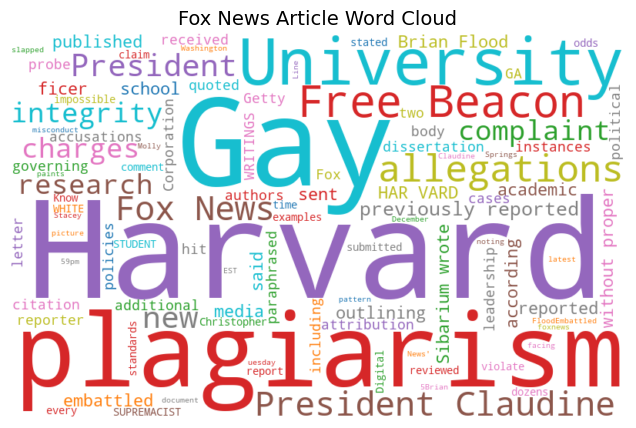

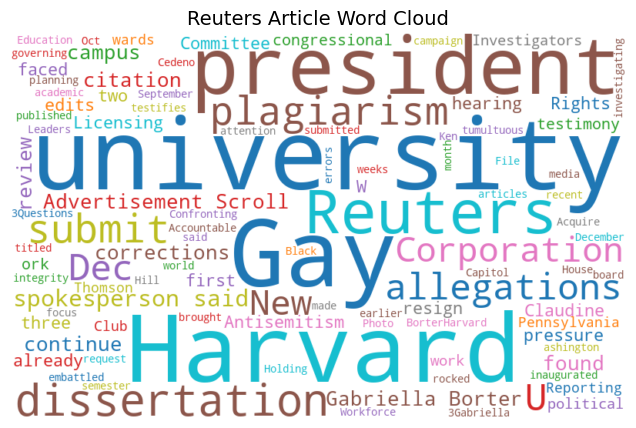

In [21]:
# Step 8: Create word clouds for each article

# Combine NLTK stopwords with WordCloud’s built-in list
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')).union(STOPWORDS)

# Define a helper function
def show_wordcloud(text, title):
    wc = WordCloud(
        width=800, height=500,
        background_color='white',
        stopwords=stop_words,
        max_words=100,
        colormap='tab10'
    ).generate(text)
    
    plt.figure(figsize=(8,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14)
    plt.show()

# Generate word clouds
show_wordcloud(fox_text, "Fox News Article Word Cloud")
show_wordcloud(reuters_text, "Reuters Article Word Cloud")

Step 8 – Word Cloud Commentary

The word clouds show the most frequent terms in each article, highlighting both outlets’ focus areas.

In the Fox News article, dominant words such as “plagiarism,” “allegations,” and “charges” suggest a strong emphasis on the controversy and accusations surrounding Harvard President Claudine Gay. The tone appears more pointed, drawing attention to conflict and accountability.

The Reuters article, while also centered on “Harvard,” “Gay,” and “plagiarism,” features words like “dissertation,” “submit,” “review,” and “spokesperson,” which emphasize procedural updates and institutional responses. This reflects a more formal and neutral framing of the same issue.

Overall, the word clouds visually confirm the earlier findings: Fox News presents the story with a focus on the scandal itself, while Reuters highlights factual developments and official actions.